**数据预处理**

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 读取数据
df = pd.read_csv('data//train.csv', parse_dates=['DateTime'])

# 强制转换数值列
numeric_cols = [
    'Global_active_power', 'Global_reactive_power', 'Voltage',
    'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
    'RR', 'NBJRR1', 'NBJRR5', 'NBJRR10', 'NBJBROU'
]
columns_to_drop = ['RR', 'NBJRR5', 'NBJRR1', 'NBJRR10', 'NBJBROU']

df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
df.dropna(subset=numeric_cols, inplace=True)
df = df.drop(columns=columns_to_drop)

# 添加时间字段
df['date'] = df['DateTime'].dt.date
df['hour'] = df['DateTime'].dt.hour

# 计算 sub_metering_remainder（每分钟）
df['sub_metering_remainder'] = (df['Global_active_power'] * 1000 / 60) - (
    df['Sub_metering_1'] + df['Sub_metering_2'] + df['Sub_metering_3'])

# 聚合函数（每小时）
hourly_agg = {
    'Global_active_power': 'mean',
    'Global_reactive_power': 'mean',
    'Voltage': 'mean',
    'Global_intensity': 'mean',
    'Sub_metering_1': 'sum',  # 60 条值 -> 小时累计
    'Sub_metering_2': 'sum',
    'Sub_metering_3': 'sum',
    'sub_metering_remainder': 'sum',
}

# 按小时聚合
df_hourly = df.groupby(['date', 'hour']).agg(hourly_agg).reset_index()

# 创建 datetime 列（方便序列建模）
df_hourly['DateTime'] = pd.to_datetime(df_hourly['date'].astype(str)) + pd.to_timedelta(df_hourly['hour'], unit='h')

# 添加时间特征
# df_hourly['day_of_week'] = df_hourly['DateTime'].dt.dayofweek
# df_hourly['day_of_month'] = df_hourly['DateTime'].dt.day
# df_hourly['month'] = df_hourly['DateTime'].dt.month
# df_hourly['quarter'] = df_hourly['DateTime'].dt.quarter
# df_hourly['hour'] = df_hourly['DateTime'].dt.hour

# 重排列顺序
cols = ['DateTime'] + [c for c in df_hourly.columns if c not in ['DateTime', 'date']]
df_hourly = df_hourly[cols]

# 归一化（保留 scaler）
feature_cols = [col for col in df_hourly.columns if col != 'DateTime']
scaler = MinMaxScaler()
df_hourly_scaled = df_hourly.copy()
df_hourly_scaled[feature_cols] = scaler.fit_transform(df_hourly[feature_cols])

# 查看
print("按小时聚合后的数据：")
print(df_hourly_scaled.info())
print(df_hourly_scaled.head())


按小时聚合后的数据：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17849 entries, 0 to 17848
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   DateTime                17849 non-null  datetime64[ns]
 1   hour                    17849 non-null  float64       
 2   Global_active_power     17849 non-null  float64       
 3   Global_reactive_power   17849 non-null  float64       
 4   Voltage                 17849 non-null  float64       
 5   Global_intensity        17849 non-null  float64       
 6   Sub_metering_1          17849 non-null  float64       
 7   Sub_metering_2          17849 non-null  float64       
 8   Sub_metering_3          17849 non-null  float64       
 9   sub_metering_remainder  17849 non-null  float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 1.4 MB
None
             DateTime      hour  Global_active_power  Global_reactive_power  \
0 2006-12-16 17:0

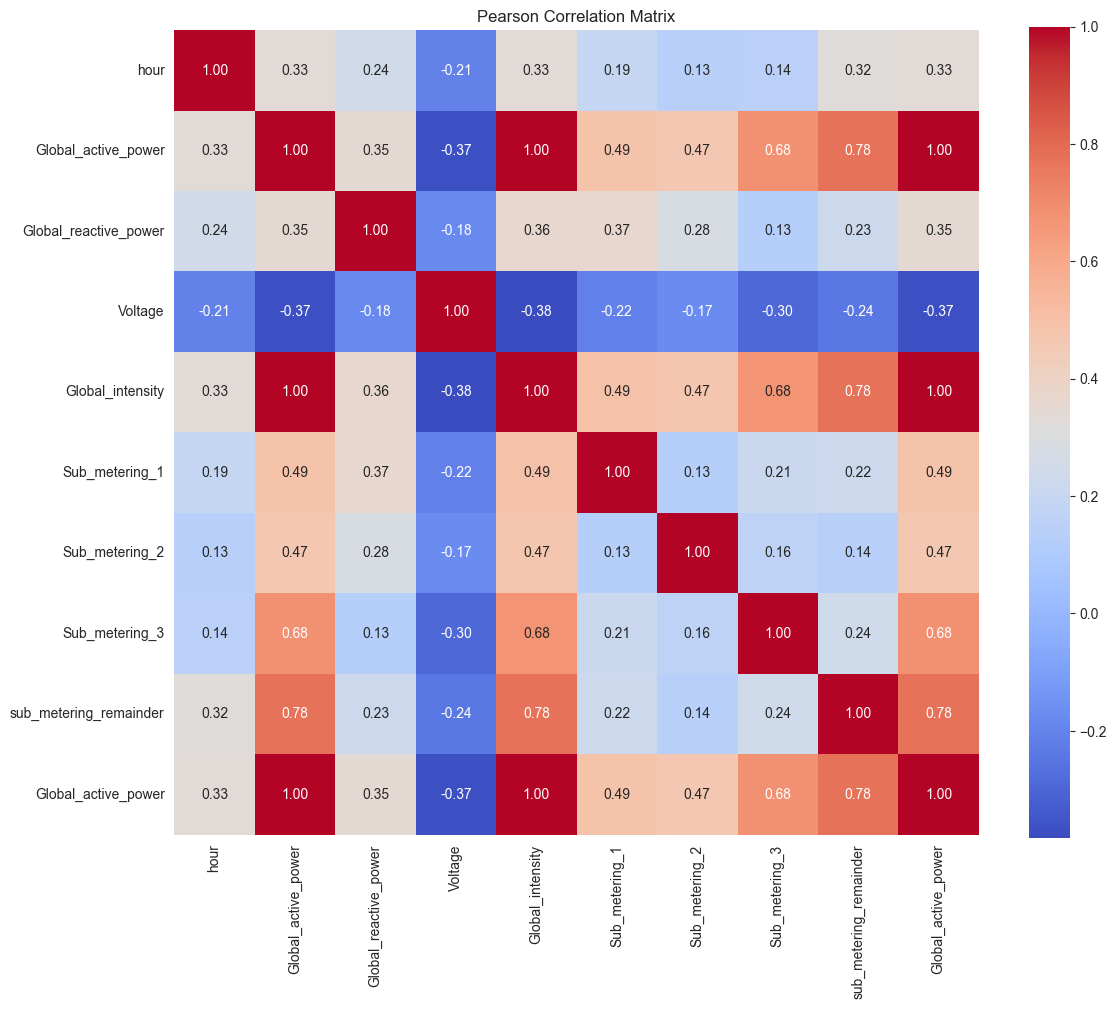

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
target_col = 'Global_active_power'
# 计算皮尔逊相关系数矩阵
corr_matrix = df_hourly_scaled[feature_cols + [target_col]].corr()

# 可视化热力图
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title("Pearson Correlation Matrix")
plt.tight_layout()
plt.show()

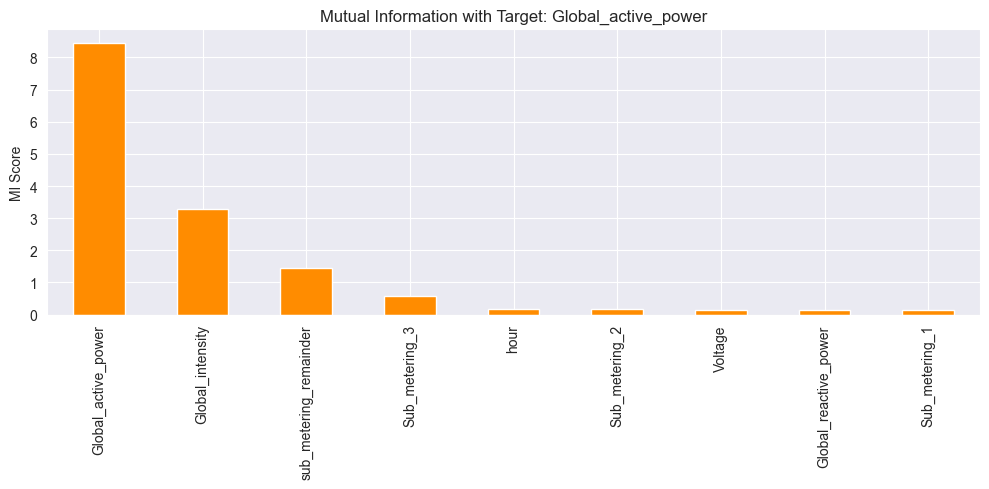

In [3]:
from sklearn.feature_selection import mutual_info_regression

X = df_hourly_scaled[feature_cols]
y = df_hourly_scaled[target_col]

mi_scores = mutual_info_regression(X, y, random_state=0)
mi_series = pd.Series(mi_scores, index=feature_cols).sort_values(ascending=False)

# 可视化
plt.figure(figsize=(10, 5))
mi_series.plot(kind='bar', color='darkorange')
plt.title(f'Mutual Information with Target: {target_col}')
plt.ylabel('MI Score')
plt.grid(True)
plt.tight_layout()
plt.show()


**构造监督学习数据集**

In [4]:
def create_supervised_data(df, input_window=168, output_window=24, target_col='Global_active_power'):
    """
    构造用于按小时聚合数据的监督学习样本。
    参数：
        df: 按小时聚合的 DataFrame，包含 DateTime 列
        input_window: 输入时间步长（如 168 = 7 天）
        output_window: 输出步长（如 24 = 1 天）
        target_col: 预测目标列（例如 'Global_active_power'）
    返回：
        X: shape = [样本数, input_window, 特征数]
        y: shape = [样本数, output_window]
    """
    data = df.copy()
    feature_cols = [col for col in data.columns if col != 'DateTime']

    X_list = []
    y_list = []

    for i in range(len(data) - input_window - output_window + 1):
        x_window = data[feature_cols].iloc[i : i + input_window].values
        y_window = data[target_col].iloc[i + input_window : i + input_window + output_window].values

        # 排除含有 NaN 的窗口
        if not (np.isnan(x_window).any() or np.isnan(y_window).any()):
            X_list.append(x_window)
            y_list.append(y_window)

    X = np.array(X_list)
    y = np.array(y_list)
    return X, y


LSTM模型设计

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.losses import Huber
def mae_with_derivative(y_true, y_pred):
    mae = K.mean(K.abs(y_pred - y_true))
    # 一阶差分
    diff_true = y_true[:, 1:] - y_true[:, :-1]
    diff_pred = y_pred[:, 1:] - y_pred[:, :-1]
    diff_loss = K.mean(K.abs(diff_true - diff_pred))
    return mae + 0.5 * diff_loss  # 你可以调节这个系数


def build_lstm_model(input_timesteps, num_features, output_timesteps):
    model = Sequential()
    model.add(LSTM(128, return_sequences=False, input_shape=(input_timesteps, num_features)))
    model.add(Dropout(0.2))
    # model.add(LSTM(128, return_sequences=False))
    # model.add(Dropout(0.2))
    model.add(Dense(output_timesteps))  # 默认线性激活
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


**模型训练函数**

In [6]:
from tensorflow.keras.callbacks import EarlyStopping
def train_lstm_model(X_train, y_train, X_val, y_val,
                     input_timesteps, num_features, output_timesteps,
                     epochs=50, batch_size=32, n_runs=3):
    from tensorflow.keras import backend as K

    mse_list = []
    mae_list = []
    best_model = None
    best_mse = float('inf')

    for run in range(n_runs):
        print(f"\n===== Run {run+1}/{n_runs} =====")
        model = build_lstm_model(input_timesteps, num_features, output_timesteps)

        early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

        model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val, y_val),  # 显式验证集
            callbacks=[early_stopping],
            verbose=2
        )

        # 验证集评估（用于模型选择）
        loss, mae = model.evaluate(X_val, y_val, verbose=0)
        mse = loss

        print(f"Run {run+1} - MSE: {mse:.6f}, MAE: {mae:.6f}")

        mse_list.append(mse)
        mae_list.append(mae)

        if mse < best_mse:
            best_mse = mse
            best_model = model

        K.clear_session()

    results = {
        'mse_mean': np.mean(mse_list),
        'mse_std': np.std(mse_list),
        'mae_mean': np.mean(mae_list),
        'mae_std': np.std(mae_list),
    }

    print("\n===== Summary =====")
    print(f"MSE mean: {results['mse_mean']:.6f}, std: {results['mse_std']:.6f}")
    print(f"MAE mean: {results['mae_mean']:.6f}, std: {results['mae_std']:.6f}")

    return best_model, results

开始训练

In [7]:

input_window = 7
output_window = 1
target_col = 'Global_active_power'

X_full, y_full = create_supervised_data(df_hourly_scaled, input_window, output_window, target_col)
print(f"X shape: {X_full.shape}, y shape: {y_full.shape}")
print(f"原始小时级数据总小时数: {df_hourly_scaled.shape[0]}")
print(f"用于建模的样本数: {len(X_full)}")

# 划分训练集和验证集
train_ratio = 0.9
split_idx = int(len(X_full) * train_ratio)
X_train, X_val = X_full[:split_idx], X_full[split_idx:]
y_train, y_val = y_full[:split_idx], y_full[split_idx:]

print(f"训练集样本数: {len(X_train)}, 验证集样本数: {len(X_val)}")

num_features = X_train.shape[2]

model, results = train_lstm_model(
    X_train, y_train, X_val, y_val,
    input_window, num_features, output_window,
    epochs=30, batch_size=32, n_runs=5
)
model.summary()

X shape: (17842, 7, 9), y shape: (17842, 1)
原始小时级数据总小时数: 17849
用于建模的样本数: 17842
训练集样本数: 16057, 验证集样本数: 1785

===== Run 1/5 =====
Epoch 1/30


C:\code\MLFinal\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


502/502 - 2s - 5ms/step - loss: 0.0110 - mae: 0.0763 - val_loss: 0.0099 - val_mae: 0.0681
Epoch 2/30
502/502 - 1s - 3ms/step - loss: 0.0094 - mae: 0.0693 - val_loss: 0.0095 - val_mae: 0.0683
Epoch 3/30
502/502 - 1s - 3ms/step - loss: 0.0091 - mae: 0.0679 - val_loss: 0.0092 - val_mae: 0.0669
Epoch 4/30
502/502 - 1s - 3ms/step - loss: 0.0091 - mae: 0.0674 - val_loss: 0.0091 - val_mae: 0.0688
Epoch 5/30
502/502 - 2s - 3ms/step - loss: 0.0089 - mae: 0.0667 - val_loss: 0.0090 - val_mae: 0.0669
Epoch 6/30
502/502 - 1s - 3ms/step - loss: 0.0089 - mae: 0.0665 - val_loss: 0.0091 - val_mae: 0.0656
Epoch 7/30
502/502 - 1s - 3ms/step - loss: 0.0088 - mae: 0.0658 - val_loss: 0.0090 - val_mae: 0.0671
Epoch 8/30
502/502 - 1s - 3ms/step - loss: 0.0087 - mae: 0.0652 - val_loss: 0.0088 - val_mae: 0.0661
Epoch 9/30
502/502 - 1s - 3ms/step - loss: 0.0085 - mae: 0.0647 - val_loss: 0.0088 - val_mae: 0.0668
Epoch 10/30
502/502 - 1s - 3ms/step - loss: 0.0085 - mae: 0.0643 - val_loss: 0.0088 - val_mae: 0.0653


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,357 (829.52 KB)

 Trainable params: 70,785 (276.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 141,572 (553.02 KB)

测试集+作图

In [8]:
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
df_test = pd.read_csv('data/test.csv', header=None)

# Step 2：赋完整列名（按顺序）
df_test.columns = [
    'DateTime', 'Global_active_power', 'Global_reactive_power', 'Voltage',
    'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
    'RR', 'NBJRR1', 'NBJRR5', 'NBJRR10', 'NBJBROU'
]


# 数值列转换（如有非数字或缺失，转为NaN）
df_test[numeric_cols] = df_test[numeric_cols].apply(pd.to_numeric, errors='coerce')
# 显式删除不需要字段
df_test = df_test.drop(columns=columns_to_drop)
df_test['DateTime'] = pd.to_datetime(df_test['DateTime'], errors='coerce')
df_test['date'] = df_test['DateTime'].dt.date
df_test['hour'] = df_test['DateTime'].dt.hour
# 计算 sub_metering_remainder
df_test['sub_metering_remainder'] = (df_test['Global_active_power'] * 1000 / 60) - (
    df_test['Sub_metering_1'] + df_test['Sub_metering_2'] + df_test['Sub_metering_3'])
# 按小时聚合（同训练）
df_test_hourly = df_test.groupby(['date','hour']).agg(hourly_agg).reset_index()

# 归一化（只对干净数据做）
df_test_hourly_clean = df_test_hourly.dropna()

# 归一化
df_test_hourly_scaled = df_test_hourly_clean.copy()
df_test_hourly_scaled[feature_cols] = scaler.transform(df_test_hourly_scaled[feature_cols])



def inverse_transform_target(scaler, feature_cols, data_1d, target_col='Global_active_power'):
    """
    把一维的目标列数据逆归一化。
    scaler: 训练时fit的Scaler
    feature_cols: 归一化时所有特征的列名列表
    data_1d: 目标列的一维归一化数据（如full_pred或full_true）
    返回：逆归一化后目标列一维数据
    """
    n = len(data_1d)
    temp = np.zeros((n, len(feature_cols)))
    # 找到目标列索引
    target_idx = feature_cols.index(target_col)
    temp[:, target_idx] = data_1d
    # 逆归一化
    inv_data = scaler.inverse_transform(temp)
    return inv_data[:, target_idx]
#
#
# X_test_final, y_test_final = create_supervised_data(
#     df_test_hourly_scaled,
#     input_window=input_window,
#     output_window=output_window,
#     target_col=target_col  # 一般是 'Global_active_power'
# )
# y_pred_final = model.predict(X_test_final)
#
# total_hours = input_window + (len(y_pred_final) - 1) + output_window
# pred_sum = np.zeros(total_hours)
# pred_count = np.zeros(total_hours)
# true_sum = np.zeros(total_hours)
# true_count = np.zeros(total_hours)
#
# # 小时级多窗口预测融合
# for i, (pred, true) in enumerate(zip(y_pred_final, y_test_final)):
#     start_idx = input_window + i
#     end_idx = start_idx + output_window
#
#     pred_sum[start_idx:end_idx] += pred
#     pred_count[start_idx:end_idx] += 1
#
#     true_sum[start_idx:end_idx] += true
#     true_count[start_idx:end_idx] += 1
#
# # 计算小时级平均预测与真实值
# pred_avg = np.zeros_like(pred_sum)
# true_avg = np.zeros_like(true_sum)
#
# pred_avg[pred_count > 0] = pred_sum[pred_count > 0] / pred_count[pred_count > 0]
# true_avg[true_count > 0] = true_sum[true_count > 0] / true_count[true_count > 0]
#
# # 截取模型预测时间段（剔除输入窗口前段）
# full_pred_hourly = pred_avg[input_window:]
# full_true_hourly = true_avg[input_window:]
#
# # 逆归一化小时级数据
# full_pred_inv_hourly = inverse_transform_target(scaler, feature_cols, full_pred_hourly, target_col)
# full_true_inv_hourly = inverse_transform_target(scaler, feature_cols, full_true_hourly, target_col)
#
# # 创建小时时间索引，假设你有测试集小时级数据的起始时间
# start_time = df_test_hourly_clean['Hour'].iloc[0]  # 请保证df_test_hourly_clean是小时级的测试数据
# time_index = pd.date_range(start=start_time, periods=len(full_pred_inv_hourly), freq='H')
#
# # 构造小时级DataFrame，方便后续按天聚合
# df_pred_hourly = pd.DataFrame({
#     'datetime': time_index,
#     'pred': full_pred_inv_hourly,
#     'true': full_true_inv_hourly
# })
#
# # 按天聚合（求和，适用于功率类特征的总消耗）
# df_pred_daily = df_pred_hourly.groupby(df_pred_hourly['datetime'].dt.date).agg({
#     'pred': 'sum',
#     'true': 'sum'
# }).reset_index()
#
# df_pred_daily['date'] = pd.to_datetime(df_pred_daily['datetime'])
#
# # 绘制按天聚合后的预测与真实对比图
# plt.figure(figsize=(14, 5))
# plt.plot(df_pred_daily['date'], df_pred_daily['true'], label='Ground Truth (Daily)', color='blue', linewidth=2)
# plt.plot(df_pred_daily['date'], df_pred_daily['pred'], label='Prediction (Daily)', color='orange', linestyle='--', linewidth=2)
# plt.xlabel('Date')
# plt.ylabel('Global Active Power (kW) - Daily Sum')
# plt.title('Daily Aggregated Prediction vs Ground Truth')
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()
#
# # 打印前30天结果
# print("Day | Ground Truth (kW) | Prediction (kW) | Absolute Error")
# print("-" * 50)
# for i in range(min(30, len(df_pred_daily))):
#     true_val = df_pred_daily.loc[i, 'true']
#     pred_val = df_pred_daily.loc[i, 'pred']
#     error = abs(true_val - pred_val)
#     print(f"{i:3d} | {true_val:17.4f} | {pred_val:14.4f} | {error:14.4f}")
#
# # 计算评估指标
# mse = mean_squared_error(df_pred_daily['true'], df_pred_daily['pred'])
# rmse = np.sqrt(mse)
# mae = mean_absolute_error(df_pred_daily['true'], df_pred_daily['pred'])
# errors = df_pred_daily['pred'] - df_pred_daily['true']
# std_dev = np.std(errors)
#
# print(f"测试集按天聚合评估指标:")
# print(f"MSE : {mse:.6f}")
# print(f"RMSE: {rmse:.6f}")
# print(f"MAE : {mae:.6f}")
# print(f"预测误差标准差: {std_dev:.6f}")

C:\Users\16693\AppData\Local\Temp\ipykernel_32944\733853896.py:3: DtypeWarning: Columns (1,2,3,4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test = pd.read_csv('data/test.csv', header=None)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 参数定义（24小时为例）
target_col = 'Global_active_power'
target_idx = feature_cols.index(target_col)

# 准备初始输入窗口数据 (input_window, num_features)
current_input = df_test_hourly_scaled[feature_cols].values[:input_window].copy()
num_features = current_input.shape[1]

# 计算需要预测的小时数（整个测试集小时数减去输入窗口）
total_hours = len(df_test_hourly_scaled) - input_window
# 用output_window步长滚动预测
steps = (total_hours + output_window - 1) // output_window  # 向上取整

predictions_scaled = []

for step in range(steps):
    # 模型输入必须三维 (1, input_window, num_features)
    model_input = current_input.reshape(1, input_window, num_features)
    pred_scaled = model.predict(model_input).flatten()  # 预测 output_window 步长

    predictions_scaled.append(pred_scaled)

    # 更新输入窗口：往前滑动output_window小时，右侧用预测填充目标列，其他特征填0或保持0
    new_input = np.zeros_like(current_input)
    if input_window > output_window:
        new_input[:input_window - output_window] = current_input[output_window:]
    # 用预测填充目标列
    new_input[input_window - output_window:, target_idx] = pred_scaled
    current_input = new_input

# 拼接所有预测结果
predictions_scaled = np.concatenate(predictions_scaled)
predictions_scaled = predictions_scaled[:total_hours]  # 裁剪多余部分

# 逆归一化
predictions_inv = inverse_transform_target(scaler, feature_cols, predictions_scaled, target_col)

# 真实值 (去除前input_window小时)
true_values_scaled = df_test_hourly_scaled[target_col].values[input_window:input_window+len(predictions_inv)]
true_values_inv = inverse_transform_target(scaler, feature_cols, true_values_scaled, target_col)

# 评估指标
mse = mean_squared_error(true_values_inv, predictions_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_inv, predictions_inv)

print(f"测试集评估指标:")
print(f"MSE : {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAE : {mae:.6f}")

# 绘图
hours = np.arange(len(predictions_inv))
plt.figure(figsize=(14,5))
plt.plot(hours, true_values_inv, label='Ground Truth', color='blue')
plt.plot(hours, predictions_inv, label='Rolling Prediction', color='orange', linestyle='--')
plt.xlabel('Hour from Prediction Start')
plt.ylabel('Global Active Power (kW)')
plt.title('Hourly Rolling Prediction vs Ground Truth')
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━